In [562]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import audio_class
import ridgeDTW
import os,sys
import pygraphviz as pgv # sudo apt-get install graphviz,libgraphviz-dev
from IPython.display import Audio,Image
import multiprocessing
from joblib import Parallel,delayed

os.system("taskset -p 0xff %d" % os.getpid())

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
#### Visualize Task 3 data
# global params
DATAROOT = '/media/blissbox/DATAPART1/GradStudents/longle1/DCASE2017-baseline-system/applications/data/TUT-sound-events-2017-development/'
AUDIOROOT = DATAROOT+'audio/street/'
LABELROOT = DATAROOT+'meta/street/'
fs = 44100 # Hz

In [123]:
# read data segment and labels
dataList = []
labelList = []
for fileLab in os.listdir(LABELROOT):
    print(fileLab)
    with open(LABELROOT+fileLab,'r') as fid:
        for line in fid:
            tokens = line.split('\t')
            #print(tokens)
            t1,t2,label = tokens
            t1 = float(t1)
            t2 = float(t2)
            
            #print('expected # of frames = %s' % ((tStop-tStart)*fs))
            fname,ext = fileLab.split('.')
            fs,data = audio_class.readSegment(AUDIOROOT+fname+'.wav',t1,t2)
            
            labelList.append(label)
            dataList.append(data)
    #break
    
print('len(dataList) = %s' % len(dataList))
print('np.shape(dataList[0]) = %s' % (np.shape(dataList[0]),))

a001.ann
a003.ann
a008.ann
a010.ann
a012.ann
a013.ann
a124.ann
a127.ann
a128.ann
a129.ann
a131.ann
b003.ann
b005.ann
b006.ann
b007.ann
b008.ann
b009.ann
b091.ann
b093.ann
b094.ann
b095.ann
b098.ann
b099.ann
b100.ann
len(dataList) = 729
np.shape(dataList[0]) = (2, 35043)


In [ ]:
# plot a sample event
idx = 501
S,F,T,tBlk,tInc = audio_class.spectrographic(dataList[idx][0,:],fs,0.032,0.016)

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(dataList[idx][0,:])
plt.autoscale(tight=True)

plt.subplot(212)
plt.pcolormesh(T,F,np.sqrt(S))
plt.suptitle(labelList[idx])

print('fs = %s' % fs)
Audio(dataList[idx][0,:],rate=fs)

In [158]:
#### Visualize Task 4 data
# global params
DATAROOT = '/media/blissbox/DATAPART1/GradStudents/longle1/Task-4-Large-scale-weakly-supervised-sound-event-detection-for-smart-cars/'
AUDIOROOT = DATAROOT+'testing_set_testing_set_audio_formatted_and_segmented_downloads/'
LABELROOT = DATAROOT
fs = 44100 # Hz

In [179]:
# read data segment and labels
data10sList = []
dataList = []
labelList = []
with open(LABELROOT+'/groundtruth_strong_label_testing_set.csv','r') as fid:
    for line in fid:
        tokens = line.split()
        #print(tokens)
        fileLab = tokens[0]
        t1 = float(tokens[1])
        t2 = float(tokens[2])
        label = ' '.join(tokens[3:])
        
        fileLab = 'Y'+fileLab
        #print('fileLab = %s' % fileLab)
        if not os.path.isfile(AUDIOROOT+fileLab):
            print('The file %s does not exist' % fileLab)
            continue    
        fs,data = audio_class.readSegment(AUDIOROOT+fileLab,t1,t2)
        
        labelList.append(label)
        dataList.append(data)
        
        fs,data = audio_class.readSegment(AUDIOROOT+fileLab)
        data10sList.append(data)
    
print('len(dataList) = %s' % len(dataList))
print('np.shape(dataList[0]) = %s' % (np.shape(dataList[0]),))

The file Y-s9kwrRilOY_30.000_40.000.wav does not exist
The file Y-4F1TX-T6T4_30.000_40.000.wav does not exist
The file Y-dcrL5JLmvo_11.000_21.000.wav does not exist
The file Y-s9kwrRilOY_30.000_40.000.wav does not exist
len(dataList) = 690
np.shape(dataList[0]) = (49040,)


fs = 44100


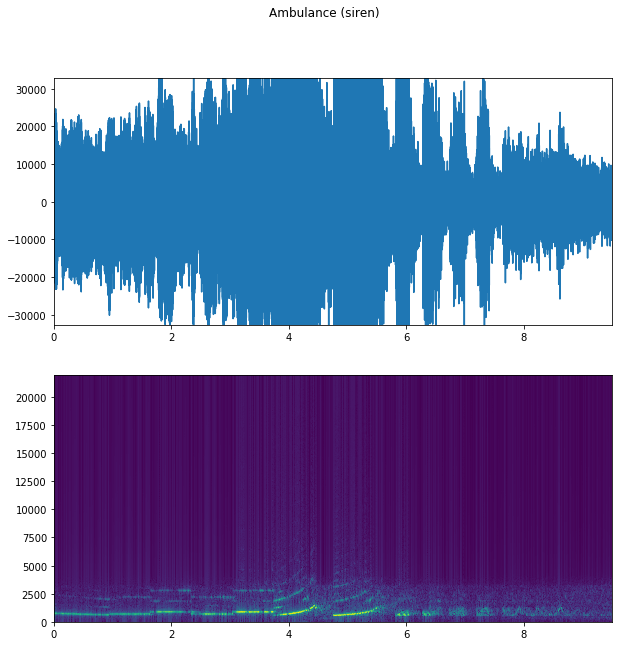

In [546]:
# plot a sample event
idx = indices[9]
S,F,T,tBlk,tInc = audio_class.spectrographic(dataList[idx],fs,0.032,0.016)

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(np.arange(len(dataList[idx]))/fs, dataList[idx])
plt.autoscale(tight=True)

plt.subplot(212)
plt.pcolormesh(T,F,np.sqrt(S))
plt.suptitle(labelList[idx])

print('fs = %s' % fs)
Audio(dataList[idx],rate=fs)

In [545]:
# Try the ridge tracker on 10s data
btTime = 0.032
tBlk = 0.032
tInc = 0.016
S,F,T,tBlk,tInc = audio_class.spectrographic(data10sList[idx],fs,tBlk,tInc)
print('tBlk = %s' % tBlk)
print('tInc = %s' % tInc)
X = ridgeDTW.ridgeTracker(S,np.median(S),btTime,tInc,isMaxPool=True)

tBlk = 0.023219954648526078
tInc = 0.011609977324263039


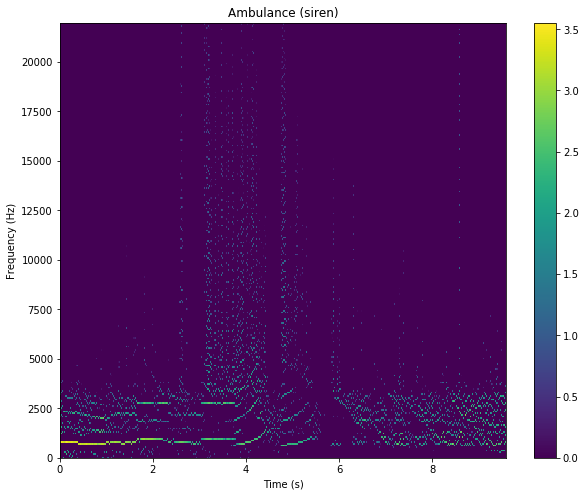

In [548]:
fig,ax = plt.subplots(figsize=(10,8))
ff,tt = audio_class.getTF(X,fs,tInc)
im = plt.pcolormesh(tt,ff,np.sqrt(X))
plt.autoscale(True,'both',True)
fig.colorbar(im,ax=ax)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title(labelList[idx])

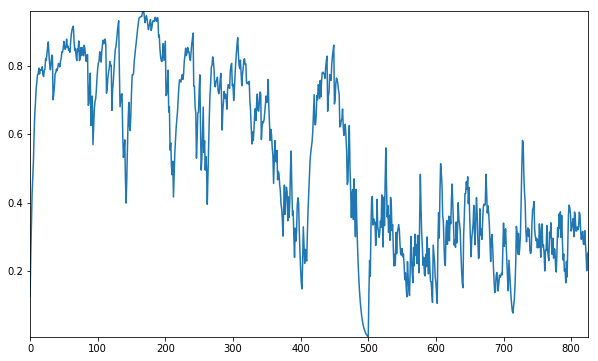

In [565]:
# investigating frame-by-frame similarity
#print(np.shape(np.expand_dims(X[:,t-1],axis=1)))
fbyfSim = np.zeros(np.shape(X)[1]-1)
for t in range(np.shape(X)[1]-1):
    fbyfSim[t] = ridgeDTW.evalSim([0,0],[np.expand_dims(X[:,t],axis=1),np.expand_dims(X[:,t+1],axis=1)])

plt.figure(figsize=(10,6))
plt.plot(sp.signal.lfilter([0.2],[1,-0.8],fbyfSim))
plt.autoscale(tight=True)

In [239]:
#### visualize in-class distances
labelSet = set(labelList)
print('len(labelSet) = %s' % len(labelSet))
print('labelSet = %s' % labelSet)

len(labelSet) = 18
labelSet = {'Car horn', 'Car alarm', 'Fire engine, fire truck (siren)', 'Screaming', 'Reversing beeps', 'Skateboard', 'Bicycle', 'Ambulance (siren)', 'Car passing by', 'Bus', 'Air horn, truck horn', 'Motorcycle', 'Civil defense siren', 'Truck', 'Train', 'Police car (siren)', 'Car', 'Train horn'}


In [ ]:
# extract AI-gram for each event
tmp1 = [i for i, lab in enumerate(labelList) if lab == "Ambulance (siren)"]
print(len(tmp1))
tmp2 = [i for i, lab in enumerate(labelList) if lab == "Screaming"]
print(len(tmp2))
indices = np.concatenate((tmp1,tmp2))

N = len(indices)
Xs = [None]*N
for k in range(N):
    S,F,T,tBlk,tInc = audio_class.spectrographic(dataList[indices[k]],fs,tBlk,tInc)
    X = ridgeDTW.ridgeTracker(S,np.median(S),btTime,tInc,isMaxPool=True)
    Xs[k] = X

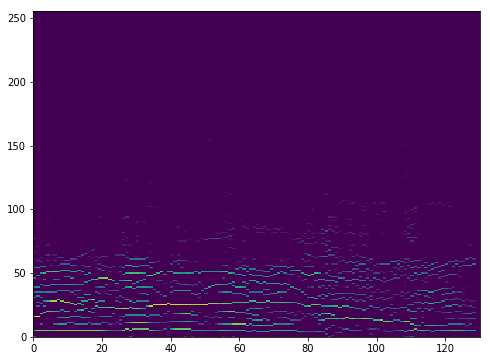

In [531]:
# sample view the AIgram of an event
idx = 40
plt.figure(figsize=(8,6))
plt.pcolormesh(Xs[idx])

In [532]:
# in-class distance/similarity matrix
def dtwPar(l,k,Xs):
    _,_,c = ridgeDTW.dtw([Xs[k],Xs[l]],1)
    return np.mean(c)

inClassSimMat = np.zeros((N,N))
for k in range(N):
    inClassSimMat[k,k+1:] = Parallel(n_jobs=multiprocessing.cpu_count())(delayed(dtwPar)(l,k,Xs) for l in range(k+1,N))

/home/blissbox/env3.6/lib/python3.6/site-packages/scipy/stats/stats.py:314: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/blissbox/env3.6/lib/python3.6/site-packages/scipy/stats/stats.py:314: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/blissbox/env3.6/lib/python3.6/site-packages/scipy/stats/stats.py:314: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/blissbox/env3.6/lib/python3.6/site-packages/scipy/stats/stats.py:314: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/blissbox/env3.6/lib/python3.6/site-packages/scipy/stats/stats.py:314: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/blissbox/env3.6/lib/python3.6/site-packages/scipy/stats/stats.py:314: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/home/blissbox/env3.6/lib/python3.6/site-packages/scipy/stats/stats.py:314: RuntimeWarning: divide by zero encountered in lo

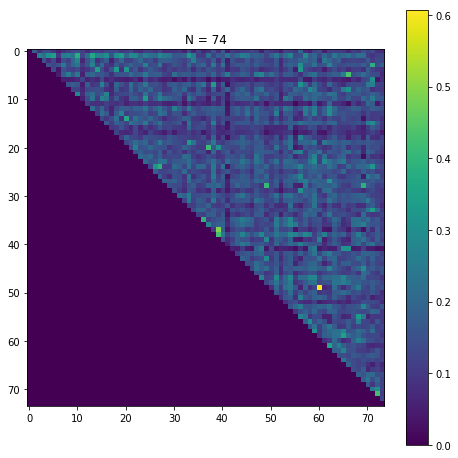

In [533]:
plt.figure(figsize=(8,8))
im = plt.imshow(inClassSimMat)
plt.title('N = %s' % N)
plt.colorbar(im, orientation='vertical')

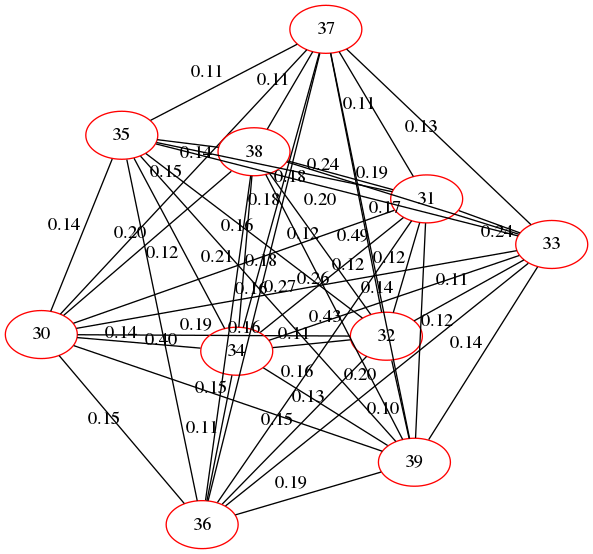

In [537]:
# use pygraphviz for graph visualization
edges = []
for k in range(30,40):
    for l in range(k+1,40):
        # must use the key 'len' to adjust edge length in graphviz/neato
        edges.append((k,l))

# use networkx to define a graph
G = pgv.AGraph()
G.node_attr['color']='red'
G.add_edges_from(edges)
#print('G.nodes() = %s' % G.nodes())
#print('G.edges() = %s' % G.edges())

# label nodes and edges
for v in G.nodes():
    G.get_node(v).attr['label']=str(v)
for e in G.edges():
    G.get_edge(e[0],e[1]).attr['label'] = '%.2f' % (inClassSimMat[int(e[0]),int(e[1])])
    G.get_edge(e[0],e[1]).attr['len'] = 20*(inClassSimMat[int(e[0]),int(e[1])])
# the 'len' attribute is needed in 'neato' layout 
#G.add_edge("5", "100", len=10.0)
           
Image(G.draw(format='png', prog='neato'))